In [168]:
# imports
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
##%matplotlib inline
from ipywidgets import *

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# if cloning repo and running on jupyter, only need to run this cell
# load dataset using pickle

datapath = os.path.join(os.getcwd(), 'datasets', 'Monkey Datasets', 'co_feats20.pkl') # run this line if in jupyter/cloned repo
print(datapath)
# datapath = os.path.join(os.getcwd(),'Monkey_Datasets', 'co_feats32.pkl') # run this line if colab
#datapath = "datasets\Monkey Datasets"
with open(datapath, 'rb') as f:
    data = pickle.load(f)
# quick lil dataframe to make it visual
dfs = []
for key in data.keys():
    dfs.append(pd.DataFrame(data[key]))
dfs = pd.concat(dfs, axis=1, keys=data.keys())
dfs	

c:\Files\UM\BMIHackathon\datasets\Monkey Datasets\co_feats20.pkl


neural                                                       \
               0          1          2          3         4         5   
0       9.600000   8.500000  13.450000  11.450000  6.000000  7.200000   
1       8.075000  10.500000   9.975000   8.700000  6.950000  7.750000   
2       9.926829   9.146341  12.975610   9.243902  5.585366  6.853659   
3       8.475000  10.625000  10.475000   9.250000  6.350000  7.475000   
4      11.575000  10.725000  11.350000  13.075000  6.200000  6.425000   
...          ...        ...        ...        ...       ...       ...   
94278  16.425000  11.300000  17.025000  11.200000  7.350000  7.600000   
94279  15.875000  10.150000  21.075000  14.250000  6.850000  6.425000   
94280  11.682927   9.975610  14.926829  14.414634  6.804878  6.926829   
94281  12.600000  11.925000  16.350000   9.175000  6.350000  7.650000   
94282  13.725000  12.150000  19.850000  11.425000  7.800000  6.300000   

                                                   ...  behavior            \
               6          7          8          9  ...         0         1   
0      10.675000   9.075000   8.325000   8.400000  ...  0.538462  0.590000   
1      11.025000   8.150000   9.350000   6.875000  ...  0.538269  0.590161   
2      16.829268   9.292683   6.756098   6.926829  ...  0.538269  0.590323   
3      14.750000   9.350000   8.750000   7.575000  ...  0.537885  0.590323   
4      13.250000   6.150000   7.750000   7.275000  ...  0.537885  0.590323   
...          ...        ...        ...        ...  ...       ...       ...   
94278  11.050000  11.400000  11.875000   8.925000  ...  0.546923  0.703710   
94279  14.300000  12.325000  10.525000   8.100000  ...  0.548077  0.746452   
94280  17.658537   8.731707   9.146341  10.365854  ...  0.550962  0.760323   
94281  12.925000  11.100000  11.700000   9.525000  ...  0.550000  0.758548   
94282  13.525000   8.000000   9.225000   9.275000  ...  0.547885  0.752581   

                                                  trialNumber targetPosition  \
              2         3         4             5           0              0   
0     -0.000192  0.000161  0.000192  1.788139e-07           1            0.5   
1      0.000000  0.000161 -0.000385 -1.613498e-04           1            0.5   
2     -0.000385  0.000000  0.000385  0.000000e+00           1            0.5   
3      0.000000  0.000000  0.000385 -6.451011e-04           1            0.5   
4      0.000385 -0.000645 -0.000192  1.290202e-03           1            0.5   
...         ...       ...       ...           ...         ...            ...   
94278  0.001154  0.042742  0.001731 -2.887088e-02        1530            0.5   
94279  0.002885  0.013871 -0.003846 -1.564550e-02        1530            0.5   
94280 -0.000962 -0.001774 -0.001154 -4.193306e-03        1530            0.5   
94281 -0.002115 -0.005968  0.000000  0.000000e+00        1530            0.5   
94282  0.000000  0.000000  0.000000  0.000000e+00        1530            0.5   

           targetWidth  
         1           0  
0      0.5       0.075  
1      0.5       0.075  
2      0.5       0.075  
3      0.5       0.075  
4      0.5       0.075  
...    ...         ...  
94278  0.8       0.075  
94279  0.8       0.075  
94280  0.8       0.075  
94281  0.8       0.075  
94282  0.8       0.075  

[94283 rows x 106 columns]

In [176]:
# group center out movements and show average trajectory, as well as corresponding neural data?
reachpositions = np.unique(data['targetPosition'], axis=0)

print(reachpositions)
reachpositions_interested = np.vstack((reachpositions[2,:], reachpositions[6,:]))

print(reachpositions_interested)

[[0.2 0.2]
 [0.2 0.5]
 [0.2 0.8]
 [0.5 0.2]
 [0.5 0.5]
 [0.5 0.8]
 [0.8 0.2]
 [0.8 0.5]
 [0.8 0.8]]
[[0.2 0.8]
 [0.8 0.2]]


In [170]:

grouped = {'neural':[], 'behavior':[]}
for position in reachpositions_interested:

    #get all trials for this target positions
    trials = np.unique(data['trialNumber'][np.argwhere((data['targetPosition'] == position).all(axis=1))])
    lens = np.stack([np.sum(data['trialNumber'] == trial) for trial in trials])

    # we need to align our trials since they are usually different lengths.
    # There are better ways to do this (time warping, etc.), but here we'll just truncate to the shortest trial of the group
    behavior = np.zeros((len(lens), np.min(lens), 6))
    neural = np.zeros((len(lens), np.min(lens), 96))
    for i, trial in enumerate(trials):
        behavior[i,:,:] = data['behavior'][(data['trialNumber'] == trial)[:,0],:][0:np.min(lens),:]
        neural[i,:,:] = data['neural'][(data['trialNumber'] == trial)[:,0],:][0:np.min(lens),:]

    grouped['behavior'].append(behavior)
    grouped['neural'].append(neural)

def plotSingleNeuronResponses(channel = 0):
    fig, ax = plt.subplots(1,2, figsize=(9,4))

    for i, position in enumerate(reachpositions):
        mean_behavior = np.mean(grouped['behavior'][i], axis=0)
        mean_neural = np.mean(grouped['neural'][i], axis=0)

        ax[0].plot(mean_behavior[:,0],mean_behavior[:,1],label=position)
        ax[1].plot(mean_neural[:,channel])

    ax[0].set(title='Average Movement Trajectory',xlabel='Index Position',ylabel='MRP Position')
    ax[1].set(ylabel='Average SBP',xlabel='Time (binsize)',title=f'Channel {channel}')
    plt.show()

In [171]:
print(grouped['neural'][1].shape)
neural_stacked_first = np.concatenate(grouped['neural'][0],axis = 0)
neural_stacked_second = np.concatenate(grouped['neural'][1],axis = 0)
print(neural_stacked_first.shape)
print(neural_stacked_second.shape)
first_end = neural_stacked_first.shape[0]
print(first_end)
neural_stacked = np.concatenate((neural_stacked_first,neural_stacked_second),axis=0)
print(neural_stacked.shape)


(82, 54, 96)
(5883, 96)
(4428, 96)
5883
(10311, 96)


In [172]:
pca = PCA(n_components=2)
input_pca = pca.fit_transform(neural_stacked)
print(input_pca.shape)
input_pca_first = input_pca[:first_end,:]
input_pca_second = input_pca[first_end:,:]
pca_vector = pca.components_[0]



(10311, 2)


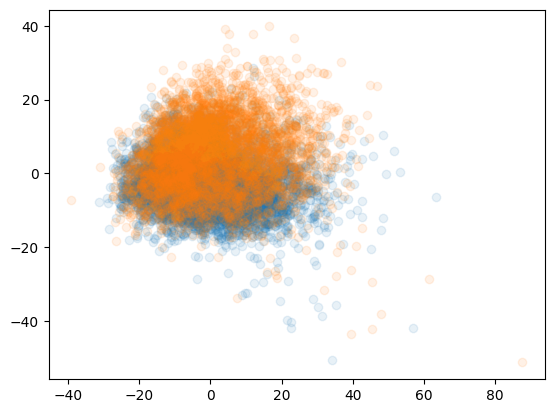

In [173]:
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')
plt.scatter(input_pca_first[:,0],input_pca_first[:,1],alpha=0.1)
plt.scatter(input_pca_second[:,0],input_pca_second[:,1],alpha=0.1)
# ax.scatter(input_pca_first[:,0],input_pca_first[:,1],input_pca_first[:,2])
# ax.scatter(input_pca_second[:,0],input_pca_second[:,1],input_pca_second[:,2])


# Show plot
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

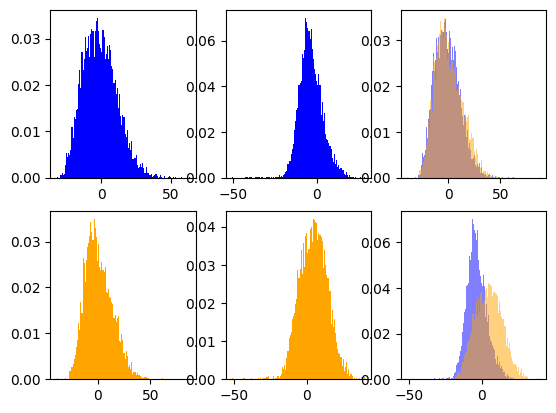

In [174]:

fig,ax  = plt.subplots(2,3)
ax[0,0].hist(input_pca_first[:,0], density=True, bins=120,color='Blue')
ax[1,0].hist(input_pca_second[:,0], density=True, bins=120,color='Orange')
ax[0,1].hist(input_pca_first[:,1], density=True, bins=120,color='Blue')
ax[1,1].hist(input_pca_second[:,1], density=True, bins=120,color='Orange')

ax[0,2].hist(input_pca_first[:,0], density=True, bins=120,color='Blue',alpha=0.5)
ax[0,2].hist(input_pca_second[:,0], density=True, bins=120,color='Orange',alpha=0.5)
ax[1,2].hist(input_pca_first[:,1], density=True, bins=120,color='Blue',alpha=0.5)
ax[1,2].hist(input_pca_second[:,1], density=True, bins=120,color='Orange',alpha=0.5)

plt.show